### If you haven't checked out my previous notebook, then I highly encourage you to first have a look at that before studying Variational Autoencoders (VAEs) so it would be a lot easier for you to understand all of what I will be explaining ahead. Notebook Link: https://shorturl.at/lRWTX

# Difference b/w **(Standard) Autoencoders** and **Variational Autoencoders**
In an autoencoder, each image is mapped directly to one point in the latent space. In a variational autoencoder, each image is instead mapped to a multivariate normal distribution around a point in the latent space. As shown in the figure below. 

<img src="https://raw.githubusercontent.com/cyb0rg14/generative-deep-learning/master/images/aeencoder_vs_vaeencoder.png" alt="The difference between the encoders in an autoencoder and a variational autoencoder" width="500" height="300">

**Let's understand this in more detailed manner.**

## Autoencoder
1. **Encoding**: Each input image is passed through an encoder network, which compresses the high-dimensional input into a lower-dimensional latent representation. This latent representation is a single point in the latent space.
2. **Latent Space**: The latent space in a simple autoencoder is deterministic, meaning each image corresponds to exactly one point in this space.
3. **Decoding**: The decoder network then takes this single point in the latent space and reconstructs the original image from it.

## Variational Autoencoder (VAE)
1. **Encoding**: Each input image is passed through an encoder network, but instead of mapping to a single point, the encoder outputs the parameters of a multivariate normal distribution (a mean vector and a covariance matrix, usually represented by a variance vector assuming independence) in the latent space.
2. **Latent Space**: For each image, this results in a Gaussian distribution around a mean point in the latent space. This distribution represents uncertainty and variability in the latent representation.
3. **Sampling**: To obtain a specific latent representation, a point is sampled from this Gaussian distribution. This sampling introduces stochasticity, meaning that each time you encode the same image, you might get slightly different latent representations.
4. **Decoding**: The decoder network then takes this sampled point and reconstructs the image from it.

## Key Points
- **Deterministic vs. Probabilistic**: In an autoencoder, the mapping from image to latent space is deterministic (one image, one point). In a VAE, the mapping is probabilistic (one image, one distribution), which captures the variability and uncertainty in the data.
- **Latent Distribution**: The use of a multivariate normal distribution in VAEs ensures that the latent space is continuous and smooth. This allows for meaningful sampling and interpolation between points in the latent space, making VAEs powerful generative models.
- **Regularization**: VAEs include a regularization term (KL divergence) that encourages the learned latent distributions to be close to a standard normal distribution, promoting smooth transitions and preventing overfitting.

In essence, while a simple autoencoder compresses an image to a single point in the latent space, a VAE represents each image as a distribution, capturing more information about the underlying data structure and enabling generative capabilities. The decoder of a variational autoencoder is identical to the decoder of a standard autoencoder, giving the overall architecture shown in figure below.

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fbrunomaga.github.io%2Fassets%2FVariational-Autoencoders%2Fvae.png&f=1&nofb=1&ipt=8382a8972479803e0c6149c8e7a6d813129c01009c9da32d978878996318c83b&ipo=images" alt="Difference b/w Autoencoders and Variational Autoencoders Visual Representation">

### **Now finally time for some hands-on implementation!**

In [1]:
# importing the required packages

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import (
    datasets,
    layers,
    models,
    losses,
    optimizers,
    metrics
)

from scipy.stats import norm

2024-07-06 20:58:23.416977: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 20:58:23.417100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 20:58:23.551654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# intialize Constants

IMG_SIZE = 32
BATCH_SIZE = 100
VALIDAION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500 # will discuss about it in later half

## **1. Prepare the Data**

In [3]:
# load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

x_train.shape, x_test.shape # checking it's shape after preprocessing

((60000, 32, 32, 1), (10000, 32, 32, 1))

## **2. Build the Variational Autoencoder**

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
# encoder
encoder_input = layers.Input(
    shape=(IMG_SIZE, IMG_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

Before actually building VAE model, let's discuss about its **Loss Function** and how is it different from standard autoencoder.

The loss function of a Variational Autoencoder (VAE) differs significantly from that of a standard autoencoder due to its probabilistic nature. Here’s an explanation of each loss function and their differences:

## Standard Autoencoder Loss Function
A standard autoencoder aims to minimize the reconstruction error, which measures how well the model can reproduce the input data from the encoded representation.

### Reconstruction Error (Loss)
- **Mean Squared Error (MSE)**: Commonly used for continuous data.

- **Binary Cross-Entropy (BCE)**: Used for binary or normalized data.

## Variational Autoencoder (VAE) Loss Function
The VAE loss function combines two components: the reconstruction loss and the regularization loss (Kullback-Leibler divergence).

#### 1. **Reconstruction Loss**
This component is similar to the standard autoencoder’s reconstruction loss and measures how well the VAE can reconstruct the input data from the latent variables.

#### 2. **Regularization Loss (KL Divergence)**
This component measures the divergence between the learned latent variable distribution and a prior distribution (typically a standard normal distribution). It ensures that the latent space is continuous and regularized.


The KL divergence loss for a VAE is given by:
$$
L_{\text{KL}} = -\frac{1}{2} \sum_{j=1}^{d} \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)
$$

where $ \mu\ $ and $ \sigma\ $ are the mean and standard deviation vectors of the latent variable distribution, and **d** is the dimensionality of the latent space.

## Combined VAE Loss Function
The total loss for a VAE is the sum of the reconstruction loss and the KL divergence:

**Loss = L(Reconstruction) + L(KL Divergence)**

In summary, while standard autoencoders aim to minimize reconstruction error, VAEs introduce a probabilistic framework and regularization through KL divergence, resulting in a more structured latent space conducive to generative modeling.

In [8]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [9]:
# create a variational autoencoder
vae = VAE(encoder, decoder)

## **3. Train the Variational Autoencoder**

In [10]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [11]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/5
 10/600 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - kl_loss: 0.0227 - reconstruction_loss: 344.6629 - total_loss: 344.6857

I0000 00:00:1720299527.569574      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720299527.592643      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


597/600 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 3.8193 - reconstruction_loss: 192.7079 - total_loss: 196.5272

W0000 00:00:1720299533.171340      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - kl_loss: 3.8242 - reconstruction_loss: 192.4530 - total_loss: 196.2772 - val_kl_loss: 4.9729 - val_loss: 141.0157 - val_reconstruction_loss: 136.0428
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 4.9572 - reconstruction_loss: 131.7809 - total_loss: 136.7381 - val_kl_loss: 5.0220 - val_loss: 138.5740 - val_reconstruction_loss: 133.5520
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 4.9713 - reconstruction_loss: 129.9841 - total_loss: 134.9555 - val_kl_loss: 5.1268 - val_loss: 137.0773 - val_reconstruction_loss: 131.9504
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 5.0264 - reconstruction_loss: 128.6432 - total_loss: 133.6696 - val_kl_loss: 5.0771 - val_loss: 135.9920 - val_reconstruction_loss: 130.9149
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 5.0746 - reconstruction_loss: 127.7460 - total_loss: 132.8206 - val_kl_loss: 5.2305 - val_loss: 135.5833 - val_reconstruction_loss: 13

## **4. Reconstruct using the Variational Autoencoder**

In [12]:
# select a subset of the test set
n_to_predict = 1000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step


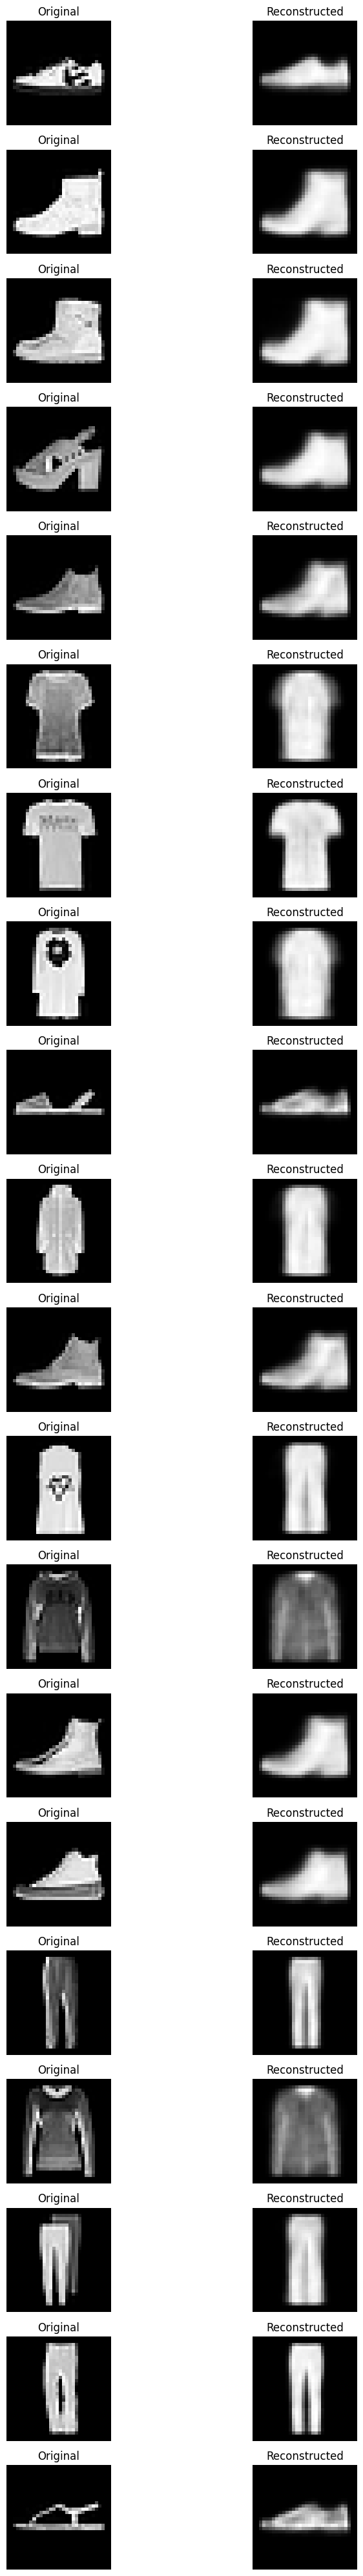

In [13]:
# create autoencoder predictions
z_mean, z_log_var, reconstructions = vae.predict(example_images)

num_images = 20
random_indices = np.random.choice(len(example_images), num_images, replace=False)

# create a figure with subplots
fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))

# plot images
for i, idx in enumerate(random_indices):
    # plot original image
    axes[i, 0].imshow(example_images[idx].reshape(32, 32), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    # plot reconstructed image
    axes[i, 1].imshow(reconstructions[idx].reshape(32, 32), cmap='gray')
    axes[i, 1].set_title('Reconstructed')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## **5. Embed using the encoder**

In [14]:
# encode the example images
z_mean, z_var, z = encoder.predict(example_images)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [15]:
# some examples of the embeddings
print(z[:10])

[[-1.4942977   0.38011518]
 [ 0.09309503 -0.85363656]
 [ 2.442638   -1.7475419 ]
 [ 2.5829058   0.92368114]
 [ 0.09034733  0.14123935]
 [ 1.8291422  -0.64125156]
 [ 0.38479945  1.0623032 ]
 [ 0.26862457  0.49655437]
 [-0.68062526  3.154426  ]
 [-1.0524958   1.8797103 ]]


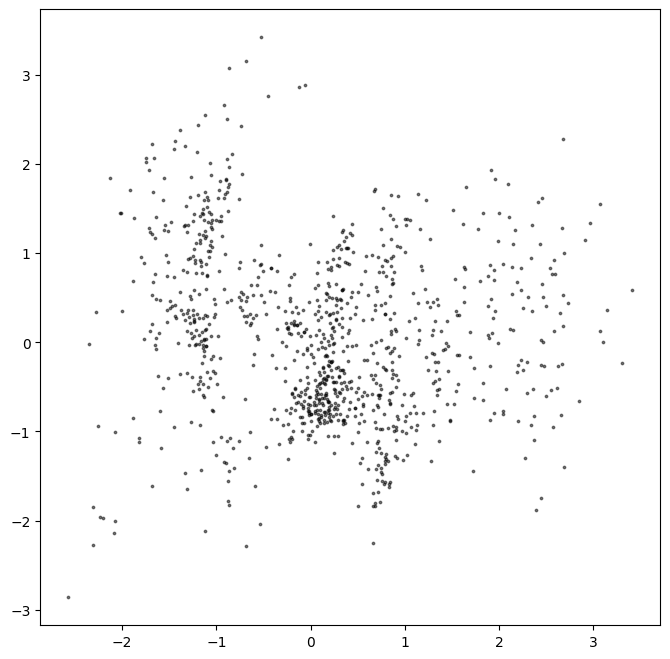

In [16]:
# show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

## **6. Generate using the decoder**

In [17]:
# sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [18]:
# decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


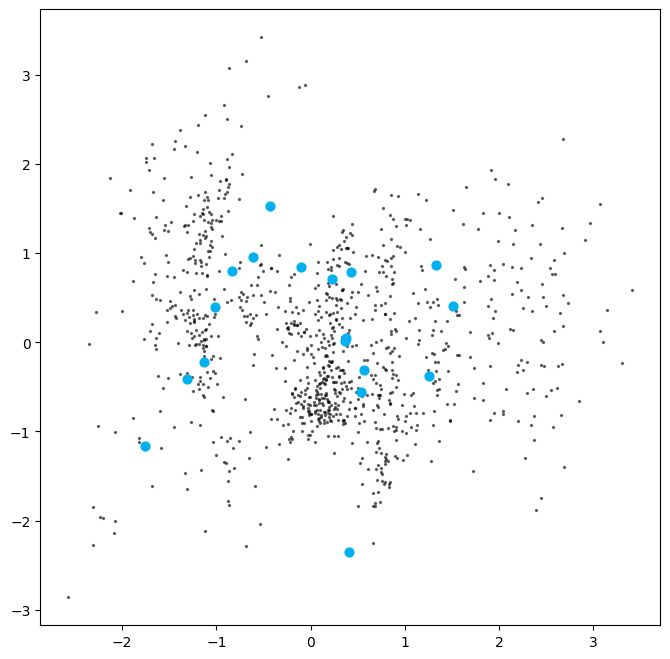

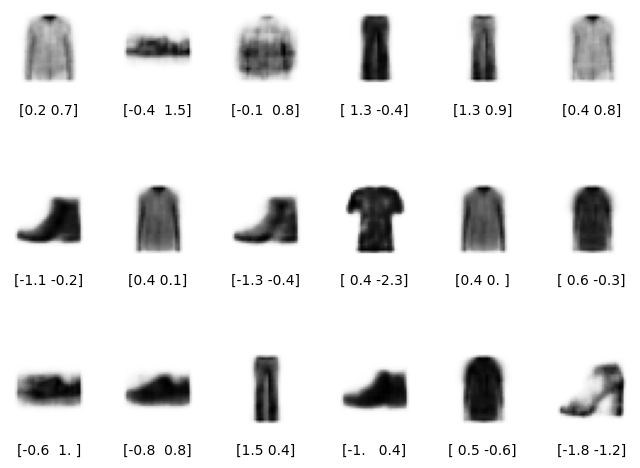

In [19]:
# draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

**And this is all from my side, today we have learned so many things. Let's rephrase those once again:**
* How VAEs are different from standard autoencoders.
* How to create a Variational Autoencoder.
* How VAEs loss function help in creating better and more diverse image.
* And finally trained and explored its generations.

If you would like to generation something else (maybe celebrities face) then you could check out this **[notebook](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/03_vae_faces/vae_faces.ipynb)** by **David Foster**.

### And yeah if you don't know, I've been running this new **Generative Deep Learning series**. Where I am learning and explaining the concepts of the future. If you want to follow along, you could check out my **[github repo](https://github.com/cyb0rg14/generative-deep-learning¶)**